# 数据预处理

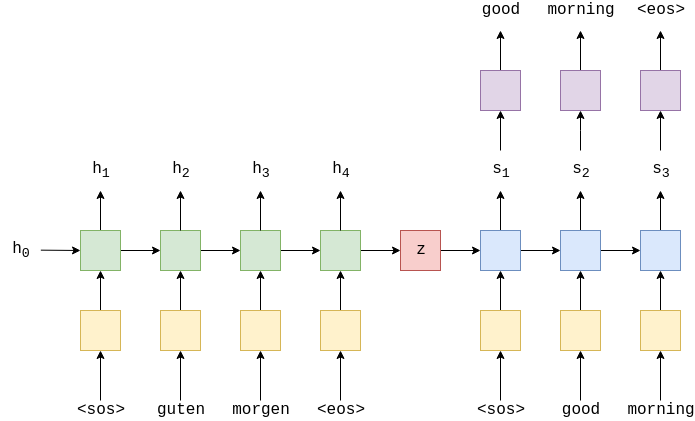

In [3]:
ins = []
outs = []
num = 1000
with open('train.zh','r',encoding = 'utf-8') as f:
    for ind,i in enumerate(f):
        # 适当数据清洗
        i = [tmp for tmp in i.strip() if tmp not in '？，。！ ']
        ins.append(i)
        # 用于快速学习模型，故此处选择1000条数据进行训练
        if ind > num:
            break
            
with open('train.en','r',encoding = 'utf-8') as f:
    for ind,i in enumerate(f):
        # 适当数据清洗
        i = [tmp for tmp in i.strip().strip('.').strip('?').strip(',').split()]
        outs.append(i)
        if ind > num:
            break
            
            
del f,i,ind,num

In [4]:
from collections import defaultdict
from operator import itemgetter
import torch.utils.data as Data
from tqdm import tqdm
import torch.nn as nn
import pickle as pk
import numpy as np
import torch
import math
import os

import time
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)
else:
    device = torch.device('cpu')
# 确定模型训练方式，GPU训练或CPU训练
parameter_copy = {
    # 为了加快模型收敛速度，此处调用基于bert模型得到的词向量，所用词向量的维度为768维
    'd_model':768, 
    # rnn的隐层维度为64
    'hid_dim':64,
    # 训练的批次为100轮
    'epoch':1000,
    # 单次训练的batch_size为100条数据
    'batch_size':100,
    # 设置序列的最大长度为100
    'max_len':100,
    # 设置两层2rnn，原文是4层
    'n_layers':2,
    # 设置最低频率的词
    'min_count':1,
    # 设置dropout，为防止过拟合
    'dropout':0.1,
    # 配置cpu、gpu
    'device':device,
    # 设置训练学习率
    'lr':0.001,
    # 优化器的参数，动量主要用于随机梯度下降
    'momentum':0.99,
}


def build_vocab(parameter,corpus):
    '''
    parameter:预设的配置项，
    corpus：训练的语料
    本函数的主要作用就是构建字典，包括有编码层的字典及解码层的字典，
    具体来说就是，本模型是数据中文语料进行翻译得到英文语料，即编码层是对中文语料的数据进行编码，解码得到英文语料的结果
    同时，本函数在处理的过程中会去除频率较低的词汇，以及调用基于bert训练好的词向量（对中文英文语料进行编码）
    '''
    global bert_client
    # 准备好用于统计词频的变量
    vocab = defaultdict(int)
    # 配置标志位，包括有补齐位:<PAD>，用于针对不定长的序列进行补齐；未知位:<UNK>，用于推理阶段得到未在字典中出现词汇的异常处理；
    # 起始位:<STA>，结束位:<END>，编解码系列模型的特色，应用于训练阶段于推理阶段，其作用对于编解码系列模型有极为重要的意义
    vocab['<PAD>'] = parameter['min_count']
    vocab['<UNK>'] = parameter['min_count']
    vocab['<STA>'] = parameter['min_count']
    vocab['<END>'] = parameter['min_count']
    # 统计词频
    for i in corpus:
        for j in i:
            vocab[j] += 1
    # 去除低频词
    for i in vocab:
        if vocab[i] < parameter['min_count']:
            del vocab[i]
    # 获取字典大小
    vocab_size = len(vocab)
    # 构建基于词-》id的字典
    voc_index = dict(zip(vocab.keys(),range(len(vocab.keys()))))
    # 构建基于id-》词的字典
    index_voc = dict(zip(range(len(vocab.keys())),vocab.keys()))
    # 调用bert训练好的词向量，若不想使用bert训练好的词向量，此处可替换为onehot形式的编码，模型侧需要添加编码层
    emb_list = bert_client.encode(list(voc_index.keys()))
    return voc_index,index_voc,vocab_size,emb_list

def batch_yield(parameter,ins,outs,shuffle = True):
    '''
    本函数的主要作用是亲手构建一个训练数据的迭代器，功能包括有：
        1、准备好面向于编码层的输入，即模型入参；
        2、准备面向于解码层，用于teacherforce的输入；
        3、准备好面向于解码层的输出，即模型的target（此处的输入输出和teacherforce的输入面向于编解码结构）
        4、在准备好输入输出及用于teacherforce的解码层输入后，对其进行补齐处理，处理成定长
    '''
    device = parameter['device']
    # 此处是一个迭代器，故第一个循环是训练的总批次，epoch
    for epoch in range(parameter['epoch']):
        # 每轮对原始数据进行随机化
        if shuffle:
            permutation = np.random.permutation(len(ins))
            ins = ins[permutation]
            outs = outs[permutation]
        # 准备好一个batch相应的lis（输入输出和teacherforce的输入）
        enc_input_list = []
        dec_input_list = []
        dec_output_list = []
        for items in tqdm(range(len(ins))):
            # 通过语料到id的字典，使用itemgetter批量对其进行处理，最终结果得到基于id的序列
            ids = itemgetter(*ins[items])(parameter['input_voc_index'])
            # 此处是对异常数据进行处理，出现的原因是使用itemgetter时，若序列长度为1则直接返回id，若序列长度大于1则返回元组
            # 为方便后面的处理对直接返回id的情形，替换为补了一个pad的元组
            ids = ids if type(ids) == type(()) else (ids,0)
            # 元组替换为数组，值得注意的是原文中对于编码层的输入也添加了sos，eos，事实上可以不使用
            enc_input_list.append(list(ids))
            # 进行相同的梳理，得到相应基于id的序列
            ids = itemgetter(*outs[items])(parameter['taget_voc_index'])
            # 值得注意的是，这边是必须使用sos和eos，因为训练阶段用于teacherforce的输入和输出必须要错位才可以进行训练，
            # 因此需要sos和eos进行区分错位，而推理阶段，获得编码层结果后进行解码时需要sos起始位开始解码，eos结束位结束推理
            if type(ids) == type(()):
                dec_input_list.append([parameter['taget_voc_index']['<STA>']]+list(ids))
                dec_output_list.append(list(ids)+[parameter['taget_voc_index']['<END>']])
            else:
                dec_input_list.append([parameter['taget_voc_index']['<STA>']]+[ids])
                dec_output_list.append([ids]+[parameter['taget_voc_index']['<END>']])
            # 当该个list大小达到batch_size大小则需要返回相应的数据
            if len(dec_output_list) >= parameter['batch_size']:
                # 先计算输出输出和teacherforce的输入序列的大小
                enc_input_len_list = [len(i) for i in enc_input_list]
                dec_input_len_list = [len(i) for i in dec_input_list]
                dec_output_len_list = [len(i) for i in dec_output_list]
                # 将对应id号替换为提前准备好的对应id号词的词向量
                # 值得注意：我们在使用build_vocab这个函数过程中准备好了词到id的字典和id到词的字典，以及基于id可以得到对应词的词向量
                # 前面的操作中已经把词转换为id，变成了id的序列，这一步工作就是基于id得到对应词的词向量，词向量的序列
                # 同时基于各项序列大小的数组，确定最大的序列长度，对其进行补齐
                enc_input_list = [parameter['input_emb'][i+[0]*(max(enc_input_len_list)-len(i))] for i in enc_input_list]
                dec_input_list = [parameter['target_emb'][i+[0]*(max(dec_input_len_list)-len(i))] for i in dec_input_list]
                dec_output_list = [i+[0]*(max(dec_output_len_list)-len(i)) for i in dec_output_list]
                # 迭代器返回，编码器输入，用于teacherforce的输入，解码器的输出，编码器输入的长度，teacherforce输入的长度，解码器的输入，当前的epoch，是否结束训练的标志
                yield torch.from_numpy(np.array(enc_input_list)).to(device),torch.from_numpy(np.array(dec_input_list)).to(device),torch.from_numpy(np.array(dec_output_list)).to(device).long(),enc_input_len_list,dec_input_len_list,dec_output_len_list,None,True
                # 数据返回后记录清空，重新开始提取数据
                enc_input_list,dec_input_list,dec_output_list = [],[],[]
        # 当前轮的最后，处理方式和上述一致
        enc_input_len_list = [len(i) for i in enc_input_list]
        dec_input_len_list = [len(i) for i in dec_input_list]
        dec_output_len_list = [len(i) for i in dec_output_list]
        enc_input_list = [parameter['input_emb'][i+[0]*(max(enc_input_len_list)-len(i))] for i in enc_input_list]
        dec_input_list = [parameter['target_emb'][i+[0]*(max(dec_input_len_list)-len(i))] for i in dec_input_list]
        dec_output_list = [i+[0]*(max(dec_output_len_list)-len(i)) for i in dec_output_list]
        yield torch.from_numpy(np.array(enc_input_list)).to(device),torch.from_numpy(np.array(dec_input_list)).to(device),torch.from_numpy(np.array(dec_output_list)).to(device).long(),enc_input_len_list,dec_input_len_list,dec_output_len_list,epoch,True
    # 完成所有轮数据的提取
    yield None,None,None,None,None,None,None,False

# 因为考虑到部分同学没有配置BertClient，无法直接调用bert训练好的词向量，因此这边提前配置好用于训练的相关参数
# 不要每次调用bert
if not os.path.exists('parameter.pkl'):
    from bert_serving.client import BertClient
    bert_client = BertClient()
    parameter = parameter_copy
    # 构建相关字典和对应的基于bert的词向量
    input_voc_index,input_index_voc,input_vocab_size,input_emb = build_vocab(parameter,ins)
    taget_voc_index,taget_index_voc,taget_vocab_size,target_emb = build_vocab(parameter,outs)
    # 将所获取的字典及对应词向量放置于parameter中，所有过程统一使用parameter进行处理
    parameter['input_voc_index'] = input_voc_index
    parameter['input_index_voc'] = input_index_voc
    parameter['taget_voc_index'] = taget_voc_index
    parameter['taget_index_voc'] = taget_index_voc
    parameter['input_vocab_size'] = input_vocab_size
    parameter['taget_vocab_size'] = taget_vocab_size
    parameter['input_emb'] = input_emb
    parameter['target_emb'] = target_emb
    del input_voc_index,input_index_voc,input_vocab_size,taget_voc_index,taget_index_voc,taget_vocab_size,input_emb,target_emb,bert_client,parameter_copy
    pk.dump(parameter,open('parameter.pkl','wb'))
else:
    # 读取已经处理好的parameter，但是考虑到模型训练的参数会发生变化，
    # 因此此处对于parameter中模型训练参数进行替换
    parameter = pk.load(open('parameter.pkl','rb'))
    for i in parameter_copy.keys():
        if i not in parameter:
            parameter[i] = parameter_copy[i]
            continue
        if parameter_copy[i] != parameter[i]:
            parameter[i] = parameter_copy[i]
    for i in parameter_copy.keys():
        print(i,':',parameter[i])
    pk.dump(parameter,open('parameter.pkl','wb'))
    del parameter_copy,i
    
data_set = batch_yield(parameter,np.array(ins),np.array(outs))
batch_x,batch_y,batch_y2,x_len,y_len,y2_len,epoch,keys = next(data_set)
batch_x.shape,batch_y.shape,x_len,y_len

d_model : 768
hid_dim : 64
epoch : 1000
batch_size : 100
max_len : 100
n_layers : 2
min_count : 1
dropout : 0.1
device : cuda:0
lr : 0.001
momentum : 0.99



  0%|                                                                                         | 0/1002 [00:00<?, ?it/s]

(torch.Size([100, 30, 768]),
 torch.Size([100, 19, 768]),
 [27,
  11,
  7,
  19,
  6,
  7,
  15,
  14,
  11,
  15,
  17,
  14,
  19,
  11,
  19,
  10,
  7,
  4,
  9,
  16,
  13,
  7,
  13,
  12,
  8,
  10,
  6,
  30,
  14,
  7,
  22,
  12,
  5,
  7,
  14,
  13,
  8,
  9,
  15,
  13,
  10,
  6,
  16,
  13,
  14,
  5,
  5,
  18,
  8,
  7,
  14,
  12,
  17,
  13,
  10,
  6,
  4,
  8,
  11,
  11,
  9,
  9,
  9,
  13,
  5,
  9,
  12,
  4,
  16,
  4,
  8,
  15,
  9,
  23,
  4,
  9,
  9,
  26,
  17,
  4,
  9,
  8,
  13,
  9,
  5,
  10,
  19,
  15,
  20,
  12,
  9,
  15,
  8,
  9,
  16,
  9,
  16,
  11,
  11,
  13],
 [19,
  10,
  7,
  9,
  5,
  6,
  12,
  8,
  11,
  7,
  10,
  11,
  15,
  8,
  12,
  9,
  10,
  4,
  7,
  14,
  9,
  5,
  8,
  10,
  6,
  7,
  4,
  12,
  7,
  8,
  11,
  9,
  6,
  8,
  9,
  9,
  12,
  3,
  9,
  7,
  8,
  6,
  9,
  12,
  15,
  7,
  4,
  11,
  4,
  6,
  11,
  12,
  15,
  6,
  8,
  9,
  3,
  7,
  8,
  5,
  8,
  6,
  9,
  9,
  4,
  7,
  11,
  5,
  14,
  5,
  6,
  10,
 

# 模型构建

seq2seq是最常见的序列到序列模型，也就是著名的编码器-解码器模型，它通常使用循环神经网络 (RNN) 将源（输入）句子编码为单个向量。然后，该向量由第二个 RNN 解码，该 RNN 通过一次生成一个单词来学习输出目标（输出）句子。

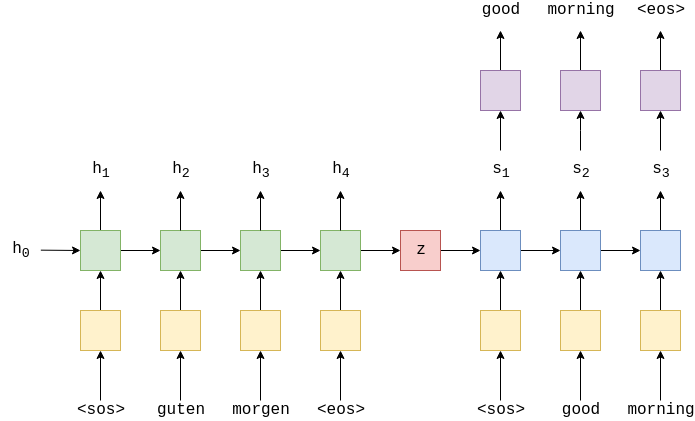

$编码层解释：$

$上图显示了一个翻译任务模型的示例:
输入guten\ \ morgen经过嵌入层（黄色），然后输入到编码器（绿色）中。同时将序列开始（sos）和序列结束（eos）标记分别附加到句子的开头和结尾。在每个时间步，编码器 RNN 的输入既是当前词的嵌入 e(x_t)，也是前一个时间步的隐藏状态 ht−1 ，输出为一个新的隐藏状态 ht 。从而RNN 可以表示为 e(x_t) 和 ht−1 的函数：$

$$h_t = EncoderRNN([e(x_t),h_(t-1)])$$

$其中所述的 RNN，它可以是任何循环架构，例如 LSTM（长短期记忆）或 GRU。$

$解码层解释：$

$在这里，X=(x1,x2,...,xT) ，其中 x_1=(sos),x_2=guten 等，初始隐藏状态 h_0 通常被初始化为零或学习参数，一旦最终单词 x_T 通过嵌入层传递到 RNN，最终隐藏状态 h_T 即可作为上下文向量，即 h_T=z 。这是整个源语句的向量表示。 通过上下文向量 z ，我们可以开始解码它以获得输出/目标句子good \ morning。同样，在这里将序列标记的开始和结束附加到目标句子，在每个时间步，解码器 RNN（蓝色）的输入是当前词 y_t 的嵌入 d(y_t) ，以及前一个时间步 s_(t−1) 的隐藏状态，其中初始，解码器隐藏状态 s_0 是上下文向量， 即s_0=z=h_T ，初始解码器隐藏状态是最终编码器隐藏状态。因此，类似于编码器，我们可以将解码器表示为：$

$$s_t = DecoderRNN([d(y_t),s_(t-1)])$$

$输出层解释：$

$值得注意的是上述e或者d均是对于词的嵌入，在原始seq2seq中使用嵌入层直接对词进行编码，但在本次任务中使用词向量进行替换。在解码器中，需要从隐藏状态到实际单词，因此在每个时间步长中需要使用线性层对s_t进行预测得到实际预测结果y_t^*$

$$y_t^* = f(s_t)$$

$note：$

$解码器中的单词总是一个接一个地生成，每个时间步长生成一个。因此使用(sos)作为解码器的第一个输入y_1，但对于随后的输入y_t,\ t>1 ，训练阶段会使用序列中实际的下一个词 y_t ，推理阶段会使用解码器预测的词y_t^* ，这一行为称为指导学习。 ,在训练/测试阶段时，通常知道目标句子中有多少个单词，因此一旦达到这么多单词，就停止生成单词。而在推理过程中，通常会继续生成单词，直到模型输出(eos)标记或生成一定数量的单词之后。$

## 编码层

$针对于原文编码层使用了4层LSTM，但为了节约时间，本次实现使用2层$


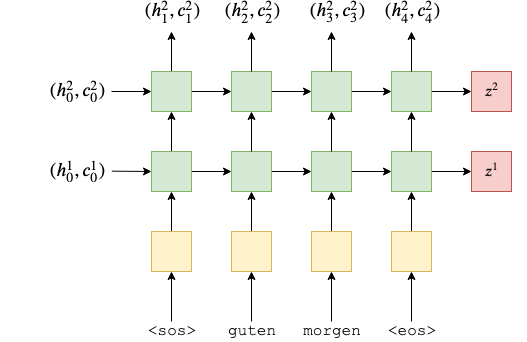

In [5]:
class Encoder(nn.Module):
    def __init__(self, parameter):
        super().__init__()
        d_model = parameter['d_model']
        hid_dim = parameter['hid_dim']
        n_layers = parameter['n_layers']
        dropout = parameter['dropout']

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(d_model, hid_dim, n_layers, dropout = dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, enc_inputs):
        # 原始输入经过dropout
        enc_inputs = self.dropout(enc_inputs)
        # 经过rnn进行特征提取
        # 此处需要回顾下lstm这块的内容，他是有隐层和细胞状态的
        outputs, (hidden, cell) = self.rnn(enc_inputs)
        # 值得注意此处使用两层rnn，因此输出的隐层状态和细胞状态是2，整体形状是（2，batch_size,隐层的维度），可以看上图
        return hidden, cell

In [6]:
test  = Encoder(parameter).to(parameter['device'])
hidden,cell = test(batch_x)
hidden.shape,cell.shape,batch_x.shape

(torch.Size([2, 100, 64]),
 torch.Size([2, 100, 64]),
 torch.Size([100, 30, 768]))

## 解码层

$解码层同样使用2层的LSTM，原文使用4层的LSTM$

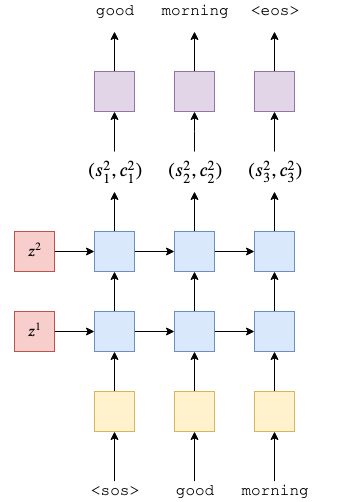

In [4]:
class Decoder(nn.Module):
    def __init__(self, parameter):
        super().__init__()
        
        d_model = parameter['d_model']
        hid_dim = parameter['hid_dim']
        n_layers = parameter['n_layers']
        dropout = parameter['dropout']
        taget_vocab_size = parameter['taget_vocab_size']
        
        self.rnn = nn.LSTM(d_model, hid_dim, n_layers, dropout = dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, taget_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, dec_input, hidden, cell):
        # 此处是用于teacherforce的解码层输入，值得注意的是，这边采用的是完全teacherforce，如果使用部分可以随机化其中部分词
        dec_input = self.dropout(dec_input)
        # 此处需要回顾下lstm这块的内容，他是有隐层和细胞状态的，使用的是编码层隐层内容和其对应的细胞状态
        output, (hidden, cell) = self.rnn(dec_input, (hidden, cell))
        # 解码层使用的就是rnn的输出，而编码层拿的就是隐层状态和细胞状态，具体可参考上图
        # 经过全连接+softmax进行输出
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

In [28]:
device = parameter['device']
enc = Encoder(parameter).to(device)
dec = Decoder(parameter).to(device)

hidden,cell = enc(batch_x)
pred,hid,cell = dec(batch_y,hidden,cell)
pred.shape,batch_y.shape,batch_y2.view(-1).shape

(torch.Size([100, 16, 2257]), torch.Size([100, 16, 768]), torch.Size([1600]))

## 完成seq2seq

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, parameter):
        super().__init__()
        device = parameter['device']
        self.encoder = Encoder(parameter).to(device)
        self.decoder = Decoder(parameter).to(device)
        
    def forward(self, enc_inputs, dec_inputs):
        # 编码层提取特征，使用最后一个隐层状态和细胞状态
        hidden, cell = self.encoder(enc_inputs)
        # 解码层使用最后一个隐层状态和细胞状态，可以选择性使用teacherforce进行训练
        pred,hid,cell = self.decoder(dec_inputs,hidden, cell)
        return pred.view(-1,pred.size(-1))

In [30]:
model = Seq2Seq(parameter)
model(batch_x,batch_y).shape,batch_y2.shape,batch_y2.size(-1),batch_y2.unsqueeze(0).shape

(torch.Size([1600, 2257]), torch.Size([100, 16]), 16, torch.Size([1, 100, 16]))

# 模型训练

In [6]:
import os
import shutil
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# 记录日志
writer = SummaryWriter('./seq2seq', comment='seq2seq')

# 构建模型
model = Seq2Seq(parameter).to(parameter['device'])

# 确定训练模式
model.train()

# 确定优化器和损失
# optimizer = torch.optim.SGD(model.parameters(),lr=parameter['lr'], momentum=parameter['momentum'], nesterov=True)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

# 准备迭代器
train_yield = batch_yield(parameter,np.array(ins),np.array(outs))

# 记录loss
loss_cal = []
min_loss = float('inf')

while 1:
    # 提取训练数据，iteration
    batch_x,batch_y,batch_y2,x_len,y_len,y2_len,epoch,keys = next(data_set)
    if keys:
        # 获取模型推理结果
        outputs = model(batch_x,batch_y)
        # 经过softmax计算相应的损失
        loss = criterion(outputs, batch_y2.view(-1))
        optimizer.zero_grad()
        # 梯度反向传播
        loss.backward()
        # 梯度限制在一定范围内
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        # 不断记录损失
        loss_cal.append(loss.item())
        if epoch is not None:
            if (epoch+1)%1 == 0:
                # 计算当前轮下平均损失
                loss_cal = sum(loss_cal)/len(loss_cal)
                # 若损失小于最小损失保存模型
                if loss_cal < min_loss:
                    min_loss = loss_cal
                    torch.save(model.state_dict(), 'model-seq2seq.h5')
                print('epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, \
                                                       parameter['epoch'],loss_cal))
            loss_cal = [loss.item()]
        
    else:
        break

D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3-5.3\envs\nlp\lib\site-packages\tensorboard\compat\tensorflow_stub\dty

epoch [1/1000], Loss: 7.5991


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3852.24it/s]

epoch [2/1000], Loss: 7.1151


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4024.11it/s]

epoch [3/1000], Loss: 6.4399


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4081.79it/s]

epoch [4/1000], Loss: 5.9620


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4341.02it/s]

epoch [5/1000], Loss: 5.7142


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4412.24it/s]

epoch [6/1000], Loss: 5.7148


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4556.52it/s]

epoch [7/1000], Loss: 5.7173


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4310.52it/s]

epoch [8/1000], Loss: 5.6493


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4476.67it/s]

epoch [9/1000], Loss: 5.6072


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4608.00it/s]

epoch [10/1000], Loss: 5.5817


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4104.49it/s]

epoch [11/1000], Loss: 5.5638


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4561.25it/s]

epoch [12/1000], Loss: 5.5143


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4543.11it/s]

epoch [13/1000], Loss: 5.4939


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4493.52it/s]

epoch [14/1000], Loss: 5.4740


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4526.39it/s]

epoch [15/1000], Loss: 5.4677


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4511.69it/s]

epoch [16/1000], Loss: 5.4486


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4367.80it/s]

epoch [17/1000], Loss: 5.4083


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4146.31it/s]

epoch [18/1000], Loss: 5.4457


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4436.25it/s]

epoch [19/1000], Loss: 5.3721


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4178.85it/s]

epoch [20/1000], Loss: 5.3245


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4294.21it/s]

epoch [21/1000], Loss: 5.4060


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4283.73it/s]

epoch [22/1000], Loss: 5.3808


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4507.66it/s]

epoch [23/1000], Loss: 5.4335


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4473.02it/s]

epoch [24/1000], Loss: 5.4050


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4132.83it/s]

epoch [25/1000], Loss: 5.3503


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4522.02it/s]

epoch [26/1000], Loss: 5.3109


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4431.51it/s]

epoch [27/1000], Loss: 5.3331


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4345.83it/s]

epoch [28/1000], Loss: 5.4160


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4598.09it/s]

epoch [29/1000], Loss: 5.3348


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4253.93it/s]

epoch [30/1000], Loss: 5.3332


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4516.91it/s]

epoch [31/1000], Loss: 5.2647


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4265.43it/s]

epoch [32/1000], Loss: 5.1479


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4359.25it/s]

epoch [33/1000], Loss: 5.2457


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4490.29it/s]

epoch [34/1000], Loss: 5.3088


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4165.35it/s]

epoch [35/1000], Loss: 5.2689


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4376.34it/s]

epoch [36/1000], Loss: 5.2722


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4254.02it/s]

epoch [37/1000], Loss: 5.3003


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4140.58it/s]

epoch [38/1000], Loss: 5.2718


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4546.21it/s]

epoch [39/1000], Loss: 5.1570


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4591.02it/s]

epoch [40/1000], Loss: 5.2117


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4529.31it/s]

epoch [41/1000], Loss: 5.2969


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4670.45it/s]

epoch [42/1000], Loss: 5.2377


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4288.87it/s]

epoch [43/1000], Loss: 5.1488


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4537.35it/s]

epoch [44/1000], Loss: 5.1160


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4369.92it/s]

epoch [45/1000], Loss: 5.1149


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4068.90it/s]

epoch [46/1000], Loss: 5.0841


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4498.96it/s]

epoch [47/1000], Loss: 5.0555


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4394.76it/s]

epoch [48/1000], Loss: 5.0513


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4292.73it/s]

epoch [49/1000], Loss: 5.0039


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4532.53it/s]

epoch [50/1000], Loss: 5.0021


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4273.55it/s]

epoch [51/1000], Loss: 5.0027


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4401.06it/s]

epoch [52/1000], Loss: 4.8979


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4294.03it/s]

epoch [53/1000], Loss: 4.8987


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4162.87it/s]

epoch [54/1000], Loss: 4.9321


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4472.08it/s]

epoch [55/1000], Loss: 4.9335


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4652.21it/s]

epoch [56/1000], Loss: 5.0008


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4364.69it/s]

epoch [57/1000], Loss: 5.0047


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4342.58it/s]

epoch [58/1000], Loss: 4.8690


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4171.06it/s]

epoch [59/1000], Loss: 4.8928


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4566.03it/s]

epoch [60/1000], Loss: 4.8986


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4311.00it/s]

epoch [61/1000], Loss: 4.8505


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3907.92it/s]

epoch [62/1000], Loss: 4.8465


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4520.03it/s]

epoch [63/1000], Loss: 4.7488


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3993.70it/s]

epoch [64/1000], Loss: 4.7597


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4579.11it/s]

epoch [65/1000], Loss: 4.7809


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4277.48it/s]

epoch [66/1000], Loss: 4.7287


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4288.98it/s]

epoch [67/1000], Loss: 4.7617


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4426.27it/s]

epoch [68/1000], Loss: 4.7365


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4314.52it/s]

epoch [69/1000], Loss: 4.7210


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4577.44it/s]

epoch [70/1000], Loss: 4.7974


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4343.60it/s]

epoch [71/1000], Loss: 4.7725


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3844.11it/s]

epoch [72/1000], Loss: 4.6833


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4533.68it/s]

epoch [73/1000], Loss: 4.6503


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4420.26it/s]

epoch [74/1000], Loss: 4.7047


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4570.10it/s]

epoch [75/1000], Loss: 4.7658


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4423.81it/s]

epoch [76/1000], Loss: 4.6608


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4472.00it/s]

epoch [77/1000], Loss: 4.6159


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3997.36it/s]

epoch [78/1000], Loss: 4.6847


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4319.51it/s]

epoch [79/1000], Loss: 4.6899


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4450.83it/s]

epoch [80/1000], Loss: 4.5269


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4586.19it/s]

epoch [81/1000], Loss: 4.4986


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4380.02it/s]

epoch [82/1000], Loss: 4.5674


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4553.03it/s]

epoch [83/1000], Loss: 4.5389


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4462.60it/s]

epoch [84/1000], Loss: 4.5816


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4199.94it/s]

epoch [85/1000], Loss: 4.6044


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4307.05it/s]

epoch [86/1000], Loss: 4.6117


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4205.56it/s]

epoch [87/1000], Loss: 4.6335


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4166.47it/s]

epoch [88/1000], Loss: 4.5537


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4258.32it/s]

epoch [89/1000], Loss: 4.5001


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4243.42it/s]

epoch [90/1000], Loss: 4.4108


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4091.04it/s]

epoch [91/1000], Loss: 4.3302


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3983.15it/s]

epoch [92/1000], Loss: 4.4550


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4421.08it/s]

epoch [93/1000], Loss: 4.5276


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3974.33it/s]

epoch [94/1000], Loss: 4.5680


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3931.53it/s]

epoch [95/1000], Loss: 4.5469


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4240.41it/s]

epoch [96/1000], Loss: 4.4683


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4285.11it/s]

epoch [97/1000], Loss: 4.4988


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3752.86it/s]

epoch [98/1000], Loss: 4.3809


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4195.61it/s]

epoch [99/1000], Loss: 4.1953


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4220.28it/s]

epoch [100/1000], Loss: 4.2859


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4252.88it/s]

epoch [101/1000], Loss: 4.3621


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3998.71it/s]

epoch [102/1000], Loss: 4.3340


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4170.56it/s]

epoch [103/1000], Loss: 4.3540


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4280.81it/s]

epoch [104/1000], Loss: 4.3982


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3976.58it/s]

epoch [105/1000], Loss: 4.3811


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4182.46it/s]

epoch [106/1000], Loss: 4.2929


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4230.51it/s]

epoch [107/1000], Loss: 4.2998


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4112.33it/s]

epoch [108/1000], Loss: 4.2635


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4199.45it/s]

epoch [109/1000], Loss: 4.1766


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4118.39it/s]

epoch [110/1000], Loss: 4.1663


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4142.01it/s]

epoch [111/1000], Loss: 4.1917


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4047.18it/s]

epoch [112/1000], Loss: 4.2237


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 3994.60it/s]

epoch [113/1000], Loss: 4.2319


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4150.91it/s]

epoch [114/1000], Loss: 4.2485


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4065.58it/s]

epoch [115/1000], Loss: 4.1180


 40%|██████████████████████████████▉                                              | 402/1002 [00:00<00:00, 4006.32it/s]

epoch [116/1000], Loss: 4.0034


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4120.06it/s]

epoch [117/1000], Loss: 4.0824


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4192.49it/s]

epoch [118/1000], Loss: 4.0538


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3721.42it/s]

epoch [119/1000], Loss: 4.0572


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4568.44it/s]

epoch [120/1000], Loss: 4.0373


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4189.68it/s]

epoch [121/1000], Loss: 4.0992


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4160.71it/s]

epoch [122/1000], Loss: 4.1020


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4295.82it/s]

epoch [123/1000], Loss: 3.9814


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4093.29it/s]

epoch [124/1000], Loss: 4.0270


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3927.39it/s]

epoch [125/1000], Loss: 3.9984


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4369.05it/s]

epoch [126/1000], Loss: 3.9035


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4464.31it/s]

epoch [127/1000], Loss: 3.9235


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4359.95it/s]

epoch [128/1000], Loss: 3.9009


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4450.68it/s]

epoch [129/1000], Loss: 3.9193


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4527.32it/s]

epoch [130/1000], Loss: 3.9741


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4485.76it/s]

epoch [131/1000], Loss: 3.8721


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4407.69it/s]

epoch [132/1000], Loss: 3.8696


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4401.00it/s]

epoch [133/1000], Loss: 3.9057


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3917.68it/s]

epoch [134/1000], Loss: 3.9521


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4243.34it/s]

epoch [135/1000], Loss: 3.9112


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4185.32it/s]

epoch [136/1000], Loss: 3.8838


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4054.17it/s]

epoch [137/1000], Loss: 3.9033


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3976.91it/s]

epoch [138/1000], Loss: 3.8739


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4279.67it/s]

epoch [139/1000], Loss: 3.8254


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4608.02it/s]

epoch [140/1000], Loss: 3.8300


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4458.13it/s]

epoch [141/1000], Loss: 3.8739


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4326.29it/s]

epoch [142/1000], Loss: 3.8323


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4535.46it/s]

epoch [143/1000], Loss: 3.7861


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4030.63it/s]

epoch [144/1000], Loss: 3.8502


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4437.82it/s]

epoch [145/1000], Loss: 3.8882


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4408.23it/s]

epoch [146/1000], Loss: 3.8407


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4069.75it/s]

epoch [147/1000], Loss: 3.7562


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4468.41it/s]

epoch [148/1000], Loss: 3.7183


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4577.87it/s]

epoch [149/1000], Loss: 3.7749


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4548.62it/s]

epoch [150/1000], Loss: 3.7575


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4494.40it/s]

epoch [151/1000], Loss: 3.7037


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4331.04it/s]

epoch [152/1000], Loss: 3.7165


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4387.23it/s]

epoch [153/1000], Loss: 3.7578


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4244.49it/s]

epoch [154/1000], Loss: 3.7203


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4204.33it/s]

epoch [155/1000], Loss: 3.7138


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4263.04it/s]

epoch [156/1000], Loss: 3.6673


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4541.31it/s]

epoch [157/1000], Loss: 3.5910


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4424.93it/s]

epoch [158/1000], Loss: 3.5487


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4307.65it/s]

epoch [159/1000], Loss: 3.5037


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4623.64it/s]

epoch [160/1000], Loss: 3.6005


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4456.17it/s]

epoch [161/1000], Loss: 3.5843


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4343.81it/s]

epoch [162/1000], Loss: 3.5542


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4164.88it/s]

epoch [163/1000], Loss: 3.6278


 80%|█████████████████████████████████████████████████████████████▍               | 800/1002 [00:00<00:00, 3983.15it/s]

epoch [164/1000], Loss: 3.6267


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4248.19it/s]

epoch [165/1000], Loss: 3.6736


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4223.66it/s]

epoch [166/1000], Loss: 3.6051


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4545.70it/s]

epoch [167/1000], Loss: 3.5276


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4103.39it/s]

epoch [168/1000], Loss: 3.5875


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4343.18it/s]

epoch [169/1000], Loss: 3.5607


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4504.79it/s]

epoch [170/1000], Loss: 3.4375


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4312.93it/s]

epoch [171/1000], Loss: 3.4582


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4319.88it/s]

epoch [172/1000], Loss: 3.4940


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4509.74it/s]

epoch [173/1000], Loss: 3.4923


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4528.61it/s]

epoch [174/1000], Loss: 3.4683


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4365.59it/s]

epoch [175/1000], Loss: 3.4068


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4464.70it/s]

epoch [176/1000], Loss: 3.4264


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4680.78it/s]

epoch [177/1000], Loss: 3.4498


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4441.96it/s]

epoch [178/1000], Loss: 3.4963


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4503.20it/s]

epoch [179/1000], Loss: 3.5462


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4557.03it/s]

epoch [180/1000], Loss: 3.4468


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4479.72it/s]

epoch [181/1000], Loss: 3.3976


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4631.71it/s]

epoch [182/1000], Loss: 3.4382


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4439.24it/s]

epoch [183/1000], Loss: 3.3115


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4400.81it/s]

epoch [184/1000], Loss: 3.2531


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4300.57it/s]

epoch [185/1000], Loss: 3.3582


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4470.85it/s]

epoch [186/1000], Loss: 3.4188


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4472.83it/s]

epoch [187/1000], Loss: 3.4634


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4459.40it/s]

epoch [188/1000], Loss: 3.4686


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4543.91it/s]

epoch [189/1000], Loss: 3.3788


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4336.70it/s]

epoch [190/1000], Loss: 3.3520


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4396.58it/s]

epoch [191/1000], Loss: 3.2995


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4659.83it/s]

epoch [192/1000], Loss: 3.3040


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4292.94it/s]

epoch [193/1000], Loss: 3.3452


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3993.50it/s]

epoch [194/1000], Loss: 3.2706


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4270.77it/s]

epoch [195/1000], Loss: 3.2843


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4129.89it/s]

epoch [196/1000], Loss: 3.2820


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4497.41it/s]

epoch [197/1000], Loss: 3.2303


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4569.45it/s]

epoch [198/1000], Loss: 3.2248


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4429.67it/s]

epoch [199/1000], Loss: 3.2320


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4486.35it/s]

epoch [200/1000], Loss: 3.2004


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4383.39it/s]

epoch [201/1000], Loss: 3.1492


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4512.57it/s]

epoch [202/1000], Loss: 3.1849


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4219.98it/s]

epoch [203/1000], Loss: 3.2017


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4029.05it/s]

epoch [204/1000], Loss: 3.1575


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4618.81it/s]

epoch [205/1000], Loss: 3.1251


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4688.96it/s]

epoch [206/1000], Loss: 3.1699


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4554.73it/s]

epoch [207/1000], Loss: 3.1283


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4712.80it/s]

epoch [208/1000], Loss: 3.0880


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4802.38it/s]

epoch [209/1000], Loss: 3.1679


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4599.11it/s]

epoch [210/1000], Loss: 3.1610


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4240.01it/s]

epoch [211/1000], Loss: 3.1357


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4542.55it/s]

epoch [212/1000], Loss: 3.0309


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4539.74it/s]

epoch [213/1000], Loss: 3.0152


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4736.44it/s]

epoch [214/1000], Loss: 3.0609


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4611.49it/s]

epoch [215/1000], Loss: 3.0446


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4536.26it/s]

epoch [216/1000], Loss: 3.0918


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4467.16it/s]

epoch [217/1000], Loss: 3.1219


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4584.61it/s]

epoch [218/1000], Loss: 3.1002


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4150.20it/s]

epoch [219/1000], Loss: 3.0484


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4830.32it/s]

epoch [220/1000], Loss: 3.0236


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4679.87it/s]

epoch [221/1000], Loss: 2.9645


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4375.06it/s]

epoch [222/1000], Loss: 2.9792


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4477.41it/s]

epoch [223/1000], Loss: 2.9836


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4626.07it/s]

epoch [224/1000], Loss: 2.9689


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4488.44it/s]

epoch [225/1000], Loss: 2.9992


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4728.79it/s]

epoch [226/1000], Loss: 2.9692


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4474.54it/s]

epoch [227/1000], Loss: 2.9785


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4581.00it/s]

epoch [228/1000], Loss: 3.0190


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4402.17it/s]

epoch [229/1000], Loss: 3.0645


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4550.30it/s]

epoch [230/1000], Loss: 3.1334


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4627.07it/s]

epoch [231/1000], Loss: 3.0997


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4677.03it/s]

epoch [232/1000], Loss: 2.9611


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4557.44it/s]

epoch [233/1000], Loss: 2.9355


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4528.89it/s]

epoch [234/1000], Loss: 2.9743


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4665.01it/s]

epoch [235/1000], Loss: 2.8798


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4266.30it/s]

epoch [236/1000], Loss: 2.8606


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4309.90it/s]

epoch [237/1000], Loss: 2.9185


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4266.22it/s]

epoch [238/1000], Loss: 2.9472


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4576.53it/s]

epoch [239/1000], Loss: 2.9372


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4722.77it/s]

epoch [240/1000], Loss: 2.9194


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4204.77it/s]

epoch [241/1000], Loss: 2.8680


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4393.20it/s]

epoch [242/1000], Loss: 2.7508


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4599.67it/s]

epoch [243/1000], Loss: 2.7563


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4693.09it/s]

epoch [244/1000], Loss: 2.8261


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4562.59it/s]

epoch [245/1000], Loss: 2.7990


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4568.94it/s]

epoch [246/1000], Loss: 2.8136


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4629.69it/s]

epoch [247/1000], Loss: 2.8319


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4656.81it/s]

epoch [248/1000], Loss: 2.7825


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4636.54it/s]

epoch [249/1000], Loss: 2.7801


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4544.29it/s]

epoch [250/1000], Loss: 2.8163


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4601.24it/s]

epoch [251/1000], Loss: 2.7910


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4424.60it/s]

epoch [252/1000], Loss: 2.7472


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4646.58it/s]

epoch [253/1000], Loss: 2.7028


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4752.46it/s]

epoch [254/1000], Loss: 2.7008


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4565.18it/s]

epoch [255/1000], Loss: 2.7268


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4607.97it/s]

epoch [256/1000], Loss: 2.6992


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4620.10it/s]

epoch [257/1000], Loss: 2.6759


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4712.47it/s]

epoch [258/1000], Loss: 2.6883


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4516.88it/s]

epoch [259/1000], Loss: 2.6982


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4599.35it/s]

epoch [260/1000], Loss: 2.7177


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4645.91it/s]

epoch [261/1000], Loss: 2.6731


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4664.13it/s]

epoch [262/1000], Loss: 2.5733


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4373.39it/s]

epoch [263/1000], Loss: 2.6224


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4713.28it/s]

epoch [264/1000], Loss: 2.6978


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4715.92it/s]

epoch [265/1000], Loss: 2.6539


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4493.66it/s]

epoch [266/1000], Loss: 2.5755


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4688.80it/s]

epoch [267/1000], Loss: 2.5903


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4416.13it/s]

epoch [268/1000], Loss: 2.6438


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4369.18it/s]

epoch [269/1000], Loss: 2.6484


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4675.92it/s]

epoch [270/1000], Loss: 2.6650


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4604.84it/s]

epoch [271/1000], Loss: 2.5865


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4267.19it/s]

epoch [272/1000], Loss: 2.4934


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4115.27it/s]

epoch [273/1000], Loss: 2.5775


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4481.65it/s]

epoch [274/1000], Loss: 2.5905


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4443.69it/s]

epoch [275/1000], Loss: 2.5741


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4381.48it/s]

epoch [276/1000], Loss: 2.6362


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4573.68it/s]

epoch [277/1000], Loss: 2.6428


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4587.35it/s]

epoch [278/1000], Loss: 2.6182


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4534.77it/s]

epoch [279/1000], Loss: 2.5822


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4577.26it/s]

epoch [280/1000], Loss: 2.5294


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4491.52it/s]

epoch [281/1000], Loss: 2.5135


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4515.35it/s]

epoch [282/1000], Loss: 2.5582


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4600.67it/s]

epoch [283/1000], Loss: 2.5577


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4788.30it/s]

epoch [284/1000], Loss: 2.4923


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4598.85it/s]

epoch [285/1000], Loss: 2.4403


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4764.01it/s]

epoch [286/1000], Loss: 2.4368


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4418.29it/s]

epoch [287/1000], Loss: 2.5347


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4288.23it/s]

epoch [288/1000], Loss: 2.5667


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4537.80it/s]

epoch [289/1000], Loss: 2.5364


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4740.91it/s]

epoch [290/1000], Loss: 2.5653


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4452.90it/s]

epoch [291/1000], Loss: 2.5336


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4422.10it/s]

epoch [292/1000], Loss: 2.4769


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4473.72it/s]

epoch [293/1000], Loss: 2.4788


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4559.80it/s]

epoch [294/1000], Loss: 2.4282


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4641.58it/s]

epoch [295/1000], Loss: 2.3555


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4799.00it/s]

epoch [296/1000], Loss: 2.4610


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4528.00it/s]

epoch [297/1000], Loss: 2.4426


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4517.66it/s]

epoch [298/1000], Loss: 2.3518


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4442.09it/s]

epoch [299/1000], Loss: 2.4060


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4557.34it/s]

epoch [300/1000], Loss: 2.4661


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4247.90it/s]

epoch [301/1000], Loss: 2.4140


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4257.31it/s]

epoch [302/1000], Loss: 2.4144


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4233.90it/s]

epoch [303/1000], Loss: 2.4961


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4448.51it/s]

epoch [304/1000], Loss: 2.4404


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4539.76it/s]

epoch [305/1000], Loss: 2.3315


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4543.01it/s]

epoch [306/1000], Loss: 2.2997


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4499.25it/s]

epoch [307/1000], Loss: 2.2856


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4669.86it/s]

epoch [308/1000], Loss: 2.2824


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4585.86it/s]

epoch [309/1000], Loss: 2.3570


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4793.67it/s]

epoch [310/1000], Loss: 2.3615


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4377.48it/s]

epoch [311/1000], Loss: 2.3941


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4566.82it/s]

epoch [312/1000], Loss: 2.4352


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4512.51it/s]

epoch [313/1000], Loss: 2.3209


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4382.33it/s]

epoch [314/1000], Loss: 2.3801


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4455.36it/s]

epoch [315/1000], Loss: 2.3584


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4473.54it/s]

epoch [316/1000], Loss: 2.3026


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4555.58it/s]

epoch [317/1000], Loss: 2.2749


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4360.47it/s]

epoch [318/1000], Loss: 2.2888


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4341.17it/s]

epoch [319/1000], Loss: 2.3209


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4443.30it/s]

epoch [320/1000], Loss: 2.2521


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4293.46it/s]

epoch [321/1000], Loss: 2.2588


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4525.83it/s]

epoch [322/1000], Loss: 2.2282


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4378.95it/s]

epoch [323/1000], Loss: 2.1484


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4726.54it/s]

epoch [324/1000], Loss: 2.1933


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4632.17it/s]

epoch [325/1000], Loss: 2.1986


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4240.70it/s]

epoch [326/1000], Loss: 2.2367


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4407.76it/s]

epoch [327/1000], Loss: 2.3116


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4666.29it/s]

epoch [328/1000], Loss: 2.2866


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4554.53it/s]

epoch [329/1000], Loss: 2.2377


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4421.96it/s]

epoch [330/1000], Loss: 2.2222


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4594.79it/s]

epoch [331/1000], Loss: 2.2638


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4477.15it/s]

epoch [332/1000], Loss: 2.2562


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4368.04it/s]

epoch [333/1000], Loss: 2.2149


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4685.84it/s]

epoch [334/1000], Loss: 2.1772


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4520.04it/s]

epoch [335/1000], Loss: 2.1353


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4660.36it/s]

epoch [336/1000], Loss: 2.1248


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4576.12it/s]

epoch [337/1000], Loss: 2.1536


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4474.26it/s]

epoch [338/1000], Loss: 2.1939


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4369.80it/s]

epoch [339/1000], Loss: 2.2123


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4457.62it/s]

epoch [340/1000], Loss: 2.1884


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4729.10it/s]

epoch [341/1000], Loss: 2.1864


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4453.54it/s]

epoch [342/1000], Loss: 2.1884


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4459.68it/s]

epoch [343/1000], Loss: 2.1138


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4254.37it/s]

epoch [344/1000], Loss: 2.0943


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4521.51it/s]

epoch [345/1000], Loss: 2.0996


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4295.02it/s]

epoch [346/1000], Loss: 2.0765


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4359.35it/s]

epoch [347/1000], Loss: 2.0817


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4595.63it/s]

epoch [348/1000], Loss: 2.1208


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4150.86it/s]

epoch [349/1000], Loss: 2.0898


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4190.21it/s]

epoch [350/1000], Loss: 2.0035


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4346.87it/s]

epoch [351/1000], Loss: 2.0288


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4439.54it/s]

epoch [352/1000], Loss: 2.0136


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4595.21it/s]

epoch [353/1000], Loss: 2.0001


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4250.97it/s]

epoch [354/1000], Loss: 2.0512


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4410.07it/s]

epoch [355/1000], Loss: 2.0675


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4353.53it/s]

epoch [356/1000], Loss: 2.0713


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4139.24it/s]

epoch [357/1000], Loss: 2.1304


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4876.10it/s]

epoch [358/1000], Loss: 2.1246


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4175.82it/s]

epoch [359/1000], Loss: 2.0879


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4337.55it/s]

epoch [360/1000], Loss: 2.0505


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4646.81it/s]

epoch [361/1000], Loss: 2.0326


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4701.65it/s]

epoch [362/1000], Loss: 2.0067


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4505.42it/s]

epoch [363/1000], Loss: 1.9650


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4505.45it/s]

epoch [364/1000], Loss: 1.9657


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4419.40it/s]

epoch [365/1000], Loss: 1.9745


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4582.21it/s]

epoch [366/1000], Loss: 1.9707


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4630.68it/s]

epoch [367/1000], Loss: 2.0025


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4565.88it/s]

epoch [368/1000], Loss: 2.0035


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4540.92it/s]

epoch [369/1000], Loss: 1.9550


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4627.13it/s]

epoch [370/1000], Loss: 1.9363


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4685.94it/s]

epoch [371/1000], Loss: 1.9653


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4747.28it/s]

epoch [372/1000], Loss: 2.0228


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4574.89it/s]

epoch [373/1000], Loss: 2.0271


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4672.93it/s]

epoch [374/1000], Loss: 1.9183


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4610.60it/s]

epoch [375/1000], Loss: 1.8947


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4474.62it/s]

epoch [376/1000], Loss: 1.9231


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4514.92it/s]

epoch [377/1000], Loss: 1.9207


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4569.96it/s]

epoch [378/1000], Loss: 1.8956


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4552.03it/s]

epoch [379/1000], Loss: 1.9155


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4542.98it/s]

epoch [380/1000], Loss: 1.9005


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4318.62it/s]

epoch [381/1000], Loss: 1.8930


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4189.02it/s]

epoch [382/1000], Loss: 1.9362


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4570.27it/s]

epoch [383/1000], Loss: 1.9330


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4615.29it/s]

epoch [384/1000], Loss: 1.9187


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4673.06it/s]

epoch [385/1000], Loss: 1.9065


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4493.73it/s]

epoch [386/1000], Loss: 1.8533


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4628.79it/s]

epoch [387/1000], Loss: 1.8630


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4574.42it/s]

epoch [388/1000], Loss: 1.8743


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4626.31it/s]

epoch [389/1000], Loss: 1.8205


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4472.44it/s]

epoch [390/1000], Loss: 1.8032


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4592.32it/s]

epoch [391/1000], Loss: 1.8519


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4632.25it/s]

epoch [392/1000], Loss: 1.8863


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4677.66it/s]

epoch [393/1000], Loss: 1.8504


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4591.98it/s]

epoch [394/1000], Loss: 1.8523


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4375.37it/s]

epoch [395/1000], Loss: 1.8883


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4759.87it/s]

epoch [396/1000], Loss: 1.7872


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4706.80it/s]

epoch [397/1000], Loss: 1.7600


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4528.93it/s]

epoch [398/1000], Loss: 1.8425


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4643.26it/s]

epoch [399/1000], Loss: 1.8449


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4585.79it/s]

epoch [400/1000], Loss: 1.8241


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4544.47it/s]

epoch [401/1000], Loss: 1.8528


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4512.98it/s]

epoch [402/1000], Loss: 1.8481


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4750.21it/s]

epoch [403/1000], Loss: 1.7826


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4798.59it/s]

epoch [404/1000], Loss: 1.7704


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4757.83it/s]

epoch [405/1000], Loss: 1.7603


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4627.18it/s]

epoch [406/1000], Loss: 1.7618


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4576.84it/s]

epoch [407/1000], Loss: 1.7671


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4678.74it/s]

epoch [408/1000], Loss: 1.7052


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4637.98it/s]

epoch [409/1000], Loss: 1.7094


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4843.07it/s]

epoch [410/1000], Loss: 1.7526


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4771.12it/s]

epoch [411/1000], Loss: 1.7860


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4671.35it/s]

epoch [412/1000], Loss: 1.7805


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4495.74it/s]

epoch [413/1000], Loss: 1.7443


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4519.96it/s]

epoch [414/1000], Loss: 1.7386


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4815.35it/s]

epoch [415/1000], Loss: 1.7411


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4643.60it/s]

epoch [416/1000], Loss: 1.7257


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4613.05it/s]

epoch [417/1000], Loss: 1.6720


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4229.73it/s]

epoch [418/1000], Loss: 1.6464


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4597.51it/s]

epoch [419/1000], Loss: 1.6666


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4578.07it/s]

epoch [420/1000], Loss: 1.6550


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4626.85it/s]

epoch [421/1000], Loss: 1.6274


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4606.92it/s]

epoch [422/1000], Loss: 1.6785


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4682.33it/s]

epoch [423/1000], Loss: 1.6878


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4614.07it/s]

epoch [424/1000], Loss: 1.6321


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4561.12it/s]

epoch [425/1000], Loss: 1.6521


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4876.29it/s]

epoch [426/1000], Loss: 1.6554


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4610.23it/s]

epoch [427/1000], Loss: 1.6537


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4475.02it/s]

epoch [428/1000], Loss: 1.6348


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4476.61it/s]

epoch [429/1000], Loss: 1.6094


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4349.52it/s]

epoch [430/1000], Loss: 1.6044


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4589.87it/s]

epoch [431/1000], Loss: 1.6324


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3914.58it/s]

epoch [432/1000], Loss: 1.6467


 40%|███████████████████████████████                                              | 405/1002 [00:00<00:00, 4024.50it/s]

epoch [433/1000], Loss: 1.6008


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4302.64it/s]

epoch [434/1000], Loss: 1.5405


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3964.49it/s]

epoch [435/1000], Loss: 1.6271


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4338.07it/s]

epoch [436/1000], Loss: 1.6829


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4468.71it/s]

epoch [437/1000], Loss: 1.7002


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4597.22it/s]

epoch [438/1000], Loss: 1.6841


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4631.52it/s]

epoch [439/1000], Loss: 1.6308


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4587.85it/s]

epoch [440/1000], Loss: 1.5671


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4335.89it/s]

epoch [441/1000], Loss: 1.5462


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4474.83it/s]

epoch [442/1000], Loss: 1.5851


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4451.01it/s]

epoch [443/1000], Loss: 1.5223


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4412.43it/s]

epoch [444/1000], Loss: 1.4939


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4576.82it/s]

epoch [445/1000], Loss: 1.5479


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4323.19it/s]

epoch [446/1000], Loss: 1.6490


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4505.20it/s]

epoch [447/1000], Loss: 1.5984


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4254.32it/s]

epoch [448/1000], Loss: 1.5642


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4511.19it/s]

epoch [449/1000], Loss: 1.5789


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4442.47it/s]

epoch [450/1000], Loss: 1.6091


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4349.43it/s]

epoch [451/1000], Loss: 1.6917


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4071.56it/s]

epoch [452/1000], Loss: 1.6194


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4294.87it/s]

epoch [453/1000], Loss: 1.5497


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4345.91it/s]

epoch [454/1000], Loss: 1.5250


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4558.94it/s]

epoch [455/1000], Loss: 1.4667


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4255.92it/s]

epoch [456/1000], Loss: 1.4627


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4137.14it/s]

epoch [457/1000], Loss: 1.4848


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4503.40it/s]

epoch [458/1000], Loss: 1.5021


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4095.44it/s]

epoch [459/1000], Loss: 1.5076


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4127.83it/s]

epoch [460/1000], Loss: 1.5640


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3829.93it/s]

epoch [461/1000], Loss: 1.5329


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4162.57it/s]

epoch [462/1000], Loss: 1.5217


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4245.94it/s]

epoch [463/1000], Loss: 1.5498


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4546.80it/s]

epoch [464/1000], Loss: 1.4842


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4280.16it/s]

epoch [465/1000], Loss: 1.4542


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4298.00it/s]

epoch [466/1000], Loss: 1.4106


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4533.77it/s]

epoch [467/1000], Loss: 1.4562


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4550.93it/s]

epoch [468/1000], Loss: 1.4594


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4660.20it/s]

epoch [469/1000], Loss: 1.4306


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4612.60it/s]

epoch [470/1000], Loss: 1.3999


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4454.42it/s]

epoch [471/1000], Loss: 1.4247


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4608.14it/s]

epoch [472/1000], Loss: 1.4995


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4469.79it/s]

epoch [473/1000], Loss: 1.4540


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4446.92it/s]

epoch [474/1000], Loss: 1.4411


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4407.34it/s]

epoch [475/1000], Loss: 1.4398


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4391.21it/s]

epoch [476/1000], Loss: 1.4325


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4601.57it/s]

epoch [477/1000], Loss: 1.4846


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4647.97it/s]

epoch [478/1000], Loss: 1.4888


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4534.17it/s]

epoch [479/1000], Loss: 1.4667


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4778.06it/s]

epoch [480/1000], Loss: 1.4729


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4626.02it/s]

epoch [481/1000], Loss: 1.4425


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4594.92it/s]

epoch [482/1000], Loss: 1.3718


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4221.09it/s]

epoch [483/1000], Loss: 1.3718


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4759.06it/s]

epoch [484/1000], Loss: 1.4321


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4575.74it/s]

epoch [485/1000], Loss: 1.4560


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4526.33it/s]

epoch [486/1000], Loss: 1.4336


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4352.37it/s]

epoch [487/1000], Loss: 1.4297


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4398.23it/s]

epoch [488/1000], Loss: 1.3880


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4634.28it/s]

epoch [489/1000], Loss: 1.3352


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4586.92it/s]

epoch [490/1000], Loss: 1.4021


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4527.53it/s]

epoch [491/1000], Loss: 1.3501


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4625.27it/s]

epoch [492/1000], Loss: 1.3035


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4623.16it/s]

epoch [493/1000], Loss: 1.3363


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4647.30it/s]

epoch [494/1000], Loss: 1.3278


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4648.99it/s]

epoch [495/1000], Loss: 1.3068


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4495.73it/s]

epoch [496/1000], Loss: 1.3251


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4417.73it/s]

epoch [497/1000], Loss: 1.3305


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4542.00it/s]

epoch [498/1000], Loss: 1.3058


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4482.48it/s]

epoch [499/1000], Loss: 1.3236


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4545.41it/s]

epoch [500/1000], Loss: 1.3121


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4550.70it/s]

epoch [501/1000], Loss: 1.2800


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4532.73it/s]

epoch [502/1000], Loss: 1.2485


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4382.20it/s]

epoch [503/1000], Loss: 1.2609


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4651.33it/s]

epoch [504/1000], Loss: 1.3020


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4420.46it/s]

epoch [505/1000], Loss: 1.2684


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4482.16it/s]

epoch [506/1000], Loss: 1.3540


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4555.95it/s]

epoch [507/1000], Loss: 1.3380


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4690.94it/s]

epoch [508/1000], Loss: 1.2513


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4637.14it/s]

epoch [509/1000], Loss: 1.3030


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4723.47it/s]

epoch [510/1000], Loss: 1.3051


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4629.98it/s]

epoch [511/1000], Loss: 1.2973


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4682.84it/s]

epoch [512/1000], Loss: 1.2742


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4458.38it/s]

epoch [513/1000], Loss: 1.2488


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4593.94it/s]

epoch [514/1000], Loss: 1.3169


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4575.43it/s]

epoch [515/1000], Loss: 1.3531


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4669.22it/s]

epoch [516/1000], Loss: 1.2905


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4299.51it/s]

epoch [517/1000], Loss: 1.2667


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4675.19it/s]

epoch [518/1000], Loss: 1.2525


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4416.54it/s]

epoch [519/1000], Loss: 1.2050


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4464.97it/s]

epoch [520/1000], Loss: 1.2517


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4579.09it/s]

epoch [521/1000], Loss: 1.2673


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4411.02it/s]

epoch [522/1000], Loss: 1.2113


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4405.79it/s]

epoch [523/1000], Loss: 1.1849


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4349.20it/s]

epoch [524/1000], Loss: 1.1664


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4283.60it/s]

epoch [525/1000], Loss: 1.2139


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4283.14it/s]

epoch [526/1000], Loss: 1.2557


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4703.87it/s]

epoch [527/1000], Loss: 1.2362


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4641.00it/s]

epoch [528/1000], Loss: 1.1656


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4479.51it/s]

epoch [529/1000], Loss: 1.1969


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4415.30it/s]

epoch [530/1000], Loss: 1.2695


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4558.44it/s]

epoch [531/1000], Loss: 1.2921


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4459.33it/s]

epoch [532/1000], Loss: 1.2415


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4655.86it/s]

epoch [533/1000], Loss: 1.1756


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4758.46it/s]

epoch [534/1000], Loss: 1.2082


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4703.60it/s]

epoch [535/1000], Loss: 1.1801


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4410.74it/s]

epoch [536/1000], Loss: 1.1918


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4377.98it/s]

epoch [537/1000], Loss: 1.2211


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4488.86it/s]

epoch [538/1000], Loss: 1.2024


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4295.73it/s]

epoch [539/1000], Loss: 1.2147


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4578.70it/s]

epoch [540/1000], Loss: 1.1897


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4476.82it/s]

epoch [541/1000], Loss: 1.2262


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4427.69it/s]

epoch [542/1000], Loss: 1.2473


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4589.19it/s]

epoch [543/1000], Loss: 1.1825


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4719.98it/s]

epoch [544/1000], Loss: 1.1427


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4544.71it/s]

epoch [545/1000], Loss: 1.1208


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4663.48it/s]

epoch [546/1000], Loss: 1.0755


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4633.42it/s]

epoch [547/1000], Loss: 1.0708


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4341.83it/s]

epoch [548/1000], Loss: 1.1257


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4543.52it/s]

epoch [549/1000], Loss: 1.1224


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4475.56it/s]

epoch [550/1000], Loss: 1.1210


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4316.25it/s]

epoch [551/1000], Loss: 1.1782


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4644.02it/s]

epoch [552/1000], Loss: 1.1562


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4417.97it/s]

epoch [553/1000], Loss: 1.1364


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4619.34it/s]

epoch [554/1000], Loss: 1.0970


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4506.77it/s]

epoch [555/1000], Loss: 1.0631


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4443.74it/s]

epoch [556/1000], Loss: 1.1216


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4425.95it/s]

epoch [557/1000], Loss: 1.1211


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4477.71it/s]

epoch [558/1000], Loss: 1.1156


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4323.72it/s]

epoch [559/1000], Loss: 1.1494


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4350.94it/s]

epoch [560/1000], Loss: 1.1034


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4503.22it/s]

epoch [561/1000], Loss: 1.0530


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4230.34it/s]

epoch [562/1000], Loss: 1.0836


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4543.96it/s]

epoch [563/1000], Loss: 1.1452


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4501.66it/s]

epoch [564/1000], Loss: 1.1377


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4409.71it/s]

epoch [565/1000], Loss: 1.0697


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4492.87it/s]

epoch [566/1000], Loss: 1.0665


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4537.62it/s]

epoch [567/1000], Loss: 1.1013


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4206.91it/s]

epoch [568/1000], Loss: 1.1135


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4389.65it/s]

epoch [569/1000], Loss: 1.1091


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4500.50it/s]

epoch [570/1000], Loss: 1.1039


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4544.56it/s]

epoch [571/1000], Loss: 1.0928


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4324.85it/s]

epoch [572/1000], Loss: 1.0918


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4317.85it/s]

epoch [573/1000], Loss: 1.0546


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4159.43it/s]

epoch [574/1000], Loss: 1.0876


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4411.87it/s]

epoch [575/1000], Loss: 1.1391


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4214.43it/s]

epoch [576/1000], Loss: 1.0890


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4348.38it/s]

epoch [577/1000], Loss: 1.0787


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4323.28it/s]

epoch [578/1000], Loss: 1.0412


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4459.16it/s]

epoch [579/1000], Loss: 0.9973


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4138.09it/s]

epoch [580/1000], Loss: 0.9582


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4346.88it/s]

epoch [581/1000], Loss: 0.9943


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4217.51it/s]

epoch [582/1000], Loss: 1.0470


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4359.54it/s]

epoch [583/1000], Loss: 1.0374


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4098.68it/s]

epoch [584/1000], Loss: 1.0718


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4270.52it/s]

epoch [585/1000], Loss: 1.0840


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3944.73it/s]

epoch [586/1000], Loss: 1.0492


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4108.67it/s]

epoch [587/1000], Loss: 1.0503


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4288.22it/s]

epoch [588/1000], Loss: 1.0081


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4252.98it/s]

epoch [589/1000], Loss: 0.9762


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4398.98it/s]

epoch [590/1000], Loss: 1.0191


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4180.37it/s]

epoch [591/1000], Loss: 0.9991


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4227.76it/s]

epoch [592/1000], Loss: 0.9464


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4159.51it/s]

epoch [593/1000], Loss: 0.9350


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4229.66it/s]

epoch [594/1000], Loss: 0.9310


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3743.04it/s]

epoch [595/1000], Loss: 0.9573


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4130.54it/s]

epoch [596/1000], Loss: 0.9527


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4149.69it/s]

epoch [597/1000], Loss: 0.9652


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 3962.57it/s]

epoch [598/1000], Loss: 0.9822


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4136.16it/s]

epoch [599/1000], Loss: 0.9452


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4122.89it/s]

epoch [600/1000], Loss: 1.0106


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4137.32it/s]

epoch [601/1000], Loss: 0.9830


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4197.49it/s]

epoch [602/1000], Loss: 0.9254


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4305.50it/s]

epoch [603/1000], Loss: 0.9857


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4211.17it/s]

epoch [604/1000], Loss: 0.9944


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3756.26it/s]

epoch [605/1000], Loss: 1.0577


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4143.05it/s]

epoch [606/1000], Loss: 1.0437


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4230.06it/s]

epoch [607/1000], Loss: 0.9713


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4194.72it/s]

epoch [608/1000], Loss: 0.9896


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4334.95it/s]

epoch [609/1000], Loss: 0.9532


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4315.01it/s]

epoch [610/1000], Loss: 0.9593


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4311.22it/s]

epoch [611/1000], Loss: 0.9692


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4299.48it/s]

epoch [612/1000], Loss: 0.9543


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4350.56it/s]

epoch [613/1000], Loss: 0.9093


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4083.41it/s]

epoch [614/1000], Loss: 0.9237


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4367.15it/s]

epoch [615/1000], Loss: 0.9232


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4348.92it/s]

epoch [616/1000], Loss: 0.9051


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3899.47it/s]

epoch [617/1000], Loss: 0.9730


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4259.08it/s]

epoch [618/1000], Loss: 1.0015


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4469.02it/s]

epoch [619/1000], Loss: 0.9458


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4390.82it/s]

epoch [620/1000], Loss: 0.9108


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4436.98it/s]

epoch [621/1000], Loss: 0.9438


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4379.41it/s]

epoch [622/1000], Loss: 0.9682


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4223.54it/s]

epoch [623/1000], Loss: 0.9233


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4129.24it/s]

epoch [624/1000], Loss: 0.9247


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4346.32it/s]

epoch [625/1000], Loss: 0.9195


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4158.14it/s]

epoch [626/1000], Loss: 0.9104


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4395.86it/s]

epoch [627/1000], Loss: 0.9198


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4203.09it/s]

epoch [628/1000], Loss: 0.9079


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4435.29it/s]

epoch [629/1000], Loss: 0.8650


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4289.72it/s]

epoch [630/1000], Loss: 0.8446


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4321.88it/s]

epoch [631/1000], Loss: 0.8761


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4146.59it/s]

epoch [632/1000], Loss: 0.8845


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4307.80it/s]

epoch [633/1000], Loss: 0.8361


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4263.22it/s]

epoch [634/1000], Loss: 0.8411


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4527.81it/s]

epoch [635/1000], Loss: 0.8613


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4311.08it/s]

epoch [636/1000], Loss: 0.8492


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4190.32it/s]

epoch [637/1000], Loss: 0.8249


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4110.84it/s]

epoch [638/1000], Loss: 0.8793


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4357.88it/s]

epoch [639/1000], Loss: 0.8833


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4245.26it/s]

epoch [640/1000], Loss: 0.9711


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4190.22it/s]

epoch [641/1000], Loss: 1.0077


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4330.81it/s]

epoch [642/1000], Loss: 0.8686


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4108.49it/s]

epoch [643/1000], Loss: 0.9610


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4274.59it/s]

epoch [644/1000], Loss: 0.9728


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4166.70it/s]

epoch [645/1000], Loss: 0.8959


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4266.48it/s]

epoch [646/1000], Loss: 0.8641


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4323.33it/s]

epoch [647/1000], Loss: 0.7985


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4210.81it/s]

epoch [648/1000], Loss: 0.8538


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4271.86it/s]

epoch [649/1000], Loss: 0.8480


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4125.69it/s]

epoch [650/1000], Loss: 0.8327


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4188.21it/s]

epoch [651/1000], Loss: 0.8295


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4296.38it/s]

epoch [652/1000], Loss: 0.8584


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4413.98it/s]

epoch [653/1000], Loss: 0.8967


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4053.52it/s]

epoch [654/1000], Loss: 0.8128


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3958.60it/s]

epoch [655/1000], Loss: 0.7652


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3986.60it/s]

epoch [656/1000], Loss: 0.7631


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 3984.11it/s]

epoch [657/1000], Loss: 0.7369


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3879.22it/s]

epoch [658/1000], Loss: 0.7947


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3903.65it/s]

epoch [659/1000], Loss: 0.7826


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3898.72it/s]

epoch [660/1000], Loss: 0.7643


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4196.92it/s]

epoch [661/1000], Loss: 0.8539


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4003.78it/s]

epoch [662/1000], Loss: 0.8198


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3889.61it/s]

epoch [663/1000], Loss: 0.7690


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4225.90it/s]

epoch [664/1000], Loss: 0.7780


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4049.22it/s]

epoch [665/1000], Loss: 0.7300


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4246.87it/s]

epoch [666/1000], Loss: 0.7541


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3988.57it/s]

epoch [667/1000], Loss: 0.7601


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4090.10it/s]

epoch [668/1000], Loss: 0.7377


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3962.45it/s]

epoch [669/1000], Loss: 0.8152


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4167.25it/s]

epoch [670/1000], Loss: 0.8218


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4086.57it/s]

epoch [671/1000], Loss: 0.7442


 43%|█████████████████████████████████▎                                           | 433/1002 [00:00<00:00, 4290.68it/s]

epoch [672/1000], Loss: 0.7295


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3992.30it/s]

epoch [673/1000], Loss: 0.7843


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4115.47it/s]

epoch [674/1000], Loss: 0.8430


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3909.80it/s]

epoch [675/1000], Loss: 0.8457


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4145.80it/s]

epoch [676/1000], Loss: 0.8333


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4180.62it/s]

epoch [677/1000], Loss: 0.7981


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4215.21it/s]

epoch [678/1000], Loss: 0.7682


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4109.54it/s]

epoch [679/1000], Loss: 0.7831


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3786.81it/s]

epoch [680/1000], Loss: 0.7797


 49%|█████████████████████████████████████▋                                       | 490/1002 [00:00<00:00, 4869.85it/s]

epoch [681/1000], Loss: 0.7630


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4016.55it/s]

epoch [682/1000], Loss: 0.7545


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4082.48it/s]

epoch [683/1000], Loss: 0.7431


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4201.69it/s]

epoch [684/1000], Loss: 0.7257


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4272.60it/s]

epoch [685/1000], Loss: 0.7263


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4513.76it/s]

epoch [686/1000], Loss: 0.7553


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4289.61it/s]

epoch [687/1000], Loss: 0.7703


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4349.51it/s]

epoch [688/1000], Loss: 0.7538


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4218.16it/s]

epoch [689/1000], Loss: 0.7349


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4194.01it/s]

epoch [690/1000], Loss: 0.7392


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4207.47it/s]

epoch [691/1000], Loss: 0.6981


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4321.69it/s]

epoch [692/1000], Loss: 0.7133


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4241.91it/s]

epoch [693/1000], Loss: 0.7461


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4375.68it/s]

epoch [694/1000], Loss: 0.7286


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4284.40it/s]

epoch [695/1000], Loss: 0.7005


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4252.72it/s]

epoch [696/1000], Loss: 0.7039


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4436.30it/s]

epoch [697/1000], Loss: 0.8141


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4219.27it/s]

epoch [698/1000], Loss: 0.8253


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4315.37it/s]

epoch [699/1000], Loss: 0.7352


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4416.45it/s]

epoch [700/1000], Loss: 0.7470


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4487.09it/s]

epoch [701/1000], Loss: 0.6993


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4194.67it/s]

epoch [702/1000], Loss: 0.6828


 45%|██████████████████████████████████▎                                          | 447/1002 [00:00<00:00, 4464.28it/s]

epoch [703/1000], Loss: 0.6978


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4270.83it/s]

epoch [704/1000], Loss: 0.6836


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4384.20it/s]

epoch [705/1000], Loss: 0.7134


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4233.17it/s]

epoch [706/1000], Loss: 0.6813


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4221.34it/s]

epoch [707/1000], Loss: 0.6722


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4317.09it/s]

epoch [708/1000], Loss: 0.7020


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4460.54it/s]

epoch [709/1000], Loss: 0.6607


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4329.72it/s]

epoch [710/1000], Loss: 0.6489


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4201.32it/s]

epoch [711/1000], Loss: 0.6285


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4476.37it/s]

epoch [712/1000], Loss: 0.6460


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4262.04it/s]

epoch [713/1000], Loss: 0.6685


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4435.26it/s]

epoch [714/1000], Loss: 0.6861


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4183.16it/s]

epoch [715/1000], Loss: 0.7050


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4371.33it/s]

epoch [716/1000], Loss: 0.6966


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4325.62it/s]

epoch [717/1000], Loss: 0.6847


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3870.15it/s]

epoch [718/1000], Loss: 0.7628


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4224.03it/s]

epoch [719/1000], Loss: 0.8021


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4032.71it/s]

epoch [720/1000], Loss: 0.7392


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4175.09it/s]

epoch [721/1000], Loss: 0.7426


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4005.15it/s]

epoch [722/1000], Loss: 0.6763


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4286.70it/s]

epoch [723/1000], Loss: 0.6329


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4363.95it/s]

epoch [724/1000], Loss: 0.6450


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4187.29it/s]

epoch [725/1000], Loss: 0.6557


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4243.76it/s]

epoch [726/1000], Loss: 0.6832


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4252.91it/s]

epoch [727/1000], Loss: 0.7343


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4353.20it/s]

epoch [728/1000], Loss: 0.7886


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4371.08it/s]

epoch [729/1000], Loss: 0.7125


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4352.07it/s]

epoch [730/1000], Loss: 0.6310


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4372.98it/s]

epoch [731/1000], Loss: 0.6528


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4340.94it/s]

epoch [732/1000], Loss: 0.6167


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4160.17it/s]

epoch [733/1000], Loss: 0.6241


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4195.76it/s]

epoch [734/1000], Loss: 0.6880


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4108.77it/s]

epoch [735/1000], Loss: 0.6913


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4224.36it/s]

epoch [736/1000], Loss: 0.6435


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4247.06it/s]

epoch [737/1000], Loss: 0.6662


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4326.42it/s]

epoch [738/1000], Loss: 0.6740


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4168.41it/s]

epoch [739/1000], Loss: 0.6338


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4294.36it/s]

epoch [740/1000], Loss: 0.7050


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4374.95it/s]

epoch [741/1000], Loss: 0.6973


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4387.32it/s]

epoch [742/1000], Loss: 0.6187


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4136.89it/s]

epoch [743/1000], Loss: 0.6240


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3647.48it/s]

epoch [744/1000], Loss: 0.6067


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3916.36it/s]

epoch [745/1000], Loss: 0.5853


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4201.99it/s]

epoch [746/1000], Loss: 0.5857


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4188.23it/s]

epoch [747/1000], Loss: 0.5812


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4290.84it/s]

epoch [748/1000], Loss: 0.5433


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4360.26it/s]

epoch [749/1000], Loss: 0.5999


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4417.28it/s]

epoch [750/1000], Loss: 0.6205


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4340.85it/s]

epoch [751/1000], Loss: 0.5730


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3819.77it/s]

epoch [752/1000], Loss: 0.5502


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3802.47it/s]

epoch [753/1000], Loss: 0.5369


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 3987.71it/s]

epoch [754/1000], Loss: 0.5564


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4159.79it/s]

epoch [755/1000], Loss: 0.5783


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4373.78it/s]

epoch [756/1000], Loss: 0.6392


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4341.94it/s]

epoch [757/1000], Loss: 0.6402


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3900.44it/s]

epoch [758/1000], Loss: 0.5901


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4239.87it/s]

epoch [759/1000], Loss: 0.5796


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3826.49it/s]

epoch [760/1000], Loss: 0.5785


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4205.76it/s]

epoch [761/1000], Loss: 0.6167


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4197.86it/s]

epoch [762/1000], Loss: 0.6190


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4305.24it/s]

epoch [763/1000], Loss: 0.6433


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4268.86it/s]

epoch [764/1000], Loss: 0.5939


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4299.35it/s]

epoch [765/1000], Loss: 0.5076


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4203.28it/s]

epoch [766/1000], Loss: 0.5095


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4356.92it/s]

epoch [767/1000], Loss: 0.5471


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4411.63it/s]

epoch [768/1000], Loss: 0.6156


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3796.76it/s]

epoch [769/1000], Loss: 0.6129


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4021.28it/s]

epoch [770/1000], Loss: 0.5463


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4182.41it/s]

epoch [771/1000], Loss: 0.5568


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4212.14it/s]

epoch [772/1000], Loss: 0.6399


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4158.21it/s]

epoch [773/1000], Loss: 0.6038


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4147.54it/s]

epoch [774/1000], Loss: 0.5426


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3896.27it/s]

epoch [775/1000], Loss: 0.5806


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3993.65it/s]

epoch [776/1000], Loss: 0.5492


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3755.80it/s]

epoch [777/1000], Loss: 0.5140


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4071.46it/s]

epoch [778/1000], Loss: 0.5465


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3940.87it/s]

epoch [779/1000], Loss: 0.5343


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3612.65it/s]

epoch [780/1000], Loss: 0.5997


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4157.11it/s]

epoch [781/1000], Loss: 0.5925


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4027.09it/s]

epoch [782/1000], Loss: 0.4953


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3831.79it/s]

epoch [783/1000], Loss: 0.5456


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3889.79it/s]

epoch [784/1000], Loss: 0.5598


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4061.52it/s]

epoch [785/1000], Loss: 0.5427


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3958.48it/s]

epoch [786/1000], Loss: 0.5654


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3916.12it/s]

epoch [787/1000], Loss: 0.5772


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4198.81it/s]

epoch [788/1000], Loss: 0.6634


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4308.83it/s]

epoch [789/1000], Loss: 0.7362


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4331.27it/s]

epoch [790/1000], Loss: 0.6267


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4126.47it/s]

epoch [791/1000], Loss: 0.5135


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4018.53it/s]

epoch [792/1000], Loss: 0.5717


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4114.18it/s]

epoch [793/1000], Loss: 0.5627


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4022.39it/s]

epoch [794/1000], Loss: 0.4966


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4104.35it/s]

epoch [795/1000], Loss: 0.5055


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4244.16it/s]

epoch [796/1000], Loss: 0.5125


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 3939.40it/s]

epoch [797/1000], Loss: 0.5416


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4129.63it/s]

epoch [798/1000], Loss: 0.6080


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3869.26it/s]

epoch [799/1000], Loss: 0.6128


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4400.87it/s]

epoch [800/1000], Loss: 0.5373


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4010.88it/s]

epoch [801/1000], Loss: 0.4866


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4255.04it/s]

epoch [802/1000], Loss: 0.5136


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4333.25it/s]

epoch [803/1000], Loss: 0.5168


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3975.83it/s]

epoch [804/1000], Loss: 0.5432


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4402.40it/s]

epoch [805/1000], Loss: 0.5521


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4384.57it/s]

epoch [806/1000], Loss: 0.4880


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4326.03it/s]

epoch [807/1000], Loss: 0.4393


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4458.88it/s]

epoch [808/1000], Loss: 0.5125


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4278.57it/s]

epoch [809/1000], Loss: 0.5566


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3977.00it/s]

epoch [810/1000], Loss: 0.5278


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4044.78it/s]

epoch [811/1000], Loss: 0.4712


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4176.02it/s]

epoch [812/1000], Loss: 0.4804


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4348.84it/s]

epoch [813/1000], Loss: 0.5396


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4249.89it/s]

epoch [814/1000], Loss: 0.4875


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4426.52it/s]

epoch [815/1000], Loss: 0.4552


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4529.53it/s]

epoch [816/1000], Loss: 0.4737


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4515.20it/s]

epoch [817/1000], Loss: 0.4573


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4522.04it/s]

epoch [818/1000], Loss: 0.4796


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4433.88it/s]

epoch [819/1000], Loss: 0.5095


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4548.72it/s]

epoch [820/1000], Loss: 0.4840


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4490.47it/s]

epoch [821/1000], Loss: 0.4948


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4144.72it/s]

epoch [822/1000], Loss: 0.4789


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4203.76it/s]

epoch [823/1000], Loss: 0.4748


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4270.89it/s]

epoch [824/1000], Loss: 0.4757


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4136.13it/s]

epoch [825/1000], Loss: 0.4513


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4311.57it/s]

epoch [826/1000], Loss: 0.4995


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4255.55it/s]

epoch [827/1000], Loss: 0.5045


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4579.20it/s]

epoch [828/1000], Loss: 0.4834


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4243.19it/s]

epoch [829/1000], Loss: 0.4860


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4330.24it/s]

epoch [830/1000], Loss: 0.4960


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4432.84it/s]

epoch [831/1000], Loss: 0.4857


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4512.16it/s]

epoch [832/1000], Loss: 0.5149


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4353.66it/s]

epoch [833/1000], Loss: 0.4931


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4274.69it/s]

epoch [834/1000], Loss: 0.4174


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4549.61it/s]

epoch [835/1000], Loss: 0.3955


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4214.17it/s]

epoch [836/1000], Loss: 0.4286


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3707.79it/s]

epoch [837/1000], Loss: 0.4724


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4322.73it/s]

epoch [838/1000], Loss: 0.4860


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4388.19it/s]

epoch [839/1000], Loss: 0.4760


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4242.11it/s]

epoch [840/1000], Loss: 0.4510


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4436.03it/s]

epoch [841/1000], Loss: 0.4530


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4311.19it/s]

epoch [842/1000], Loss: 0.4620


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4266.78it/s]

epoch [843/1000], Loss: 0.4738


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4167.61it/s]

epoch [844/1000], Loss: 0.4947


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4112.18it/s]

epoch [845/1000], Loss: 0.4804


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4365.70it/s]

epoch [846/1000], Loss: 0.4349


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4263.56it/s]

epoch [847/1000], Loss: 0.3909


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4357.08it/s]

epoch [848/1000], Loss: 0.3933


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4148.81it/s]

epoch [849/1000], Loss: 0.4420


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4276.35it/s]

epoch [850/1000], Loss: 0.4443


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4175.29it/s]

epoch [851/1000], Loss: 0.4281


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4390.10it/s]

epoch [852/1000], Loss: 0.4342


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4390.92it/s]

epoch [853/1000], Loss: 0.4448


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4060.46it/s]

epoch [854/1000], Loss: 0.4375


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4212.93it/s]

epoch [855/1000], Loss: 0.4277


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4370.52it/s]

epoch [856/1000], Loss: 0.4662


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4163.23it/s]

epoch [857/1000], Loss: 0.4811


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4479.11it/s]

epoch [858/1000], Loss: 0.4897


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4444.16it/s]

epoch [859/1000], Loss: 0.4531


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4224.29it/s]

epoch [860/1000], Loss: 0.3999


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4408.59it/s]

epoch [861/1000], Loss: 0.3931


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4497.35it/s]

epoch [862/1000], Loss: 0.4630


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4346.59it/s]

epoch [863/1000], Loss: 0.4583


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4419.88it/s]

epoch [864/1000], Loss: 0.3878


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4424.28it/s]

epoch [865/1000], Loss: 0.4366


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4345.11it/s]

epoch [866/1000], Loss: 0.4398


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4490.69it/s]

epoch [867/1000], Loss: 0.3853


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4215.91it/s]

epoch [868/1000], Loss: 0.4215


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4191.14it/s]

epoch [869/1000], Loss: 0.5132


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3707.60it/s]

epoch [870/1000], Loss: 0.5178


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3868.94it/s]

epoch [871/1000], Loss: 0.4067


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4315.94it/s]

epoch [872/1000], Loss: 0.3857


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4251.27it/s]

epoch [873/1000], Loss: 0.4259


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4299.38it/s]

epoch [874/1000], Loss: 0.4092


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4309.18it/s]

epoch [875/1000], Loss: 0.4132


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4554.92it/s]

epoch [876/1000], Loss: 0.4292


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4500.01it/s]

epoch [877/1000], Loss: 0.4157


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4179.98it/s]

epoch [878/1000], Loss: 0.4005


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4663.43it/s]

epoch [879/1000], Loss: 0.4071


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4659.84it/s]

epoch [880/1000], Loss: 0.4290


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4650.49it/s]

epoch [881/1000], Loss: 0.3868


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4458.59it/s]

epoch [882/1000], Loss: 0.3807


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4493.33it/s]

epoch [883/1000], Loss: 0.4026


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4290.96it/s]

epoch [884/1000], Loss: 0.3983


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4342.23it/s]

epoch [885/1000], Loss: 0.3953


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4461.53it/s]

epoch [886/1000], Loss: 0.4465


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4377.59it/s]

epoch [887/1000], Loss: 0.4451


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4395.97it/s]

epoch [888/1000], Loss: 0.4187


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4322.01it/s]

epoch [889/1000], Loss: 0.4246


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4444.17it/s]

epoch [890/1000], Loss: 0.4021


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4317.50it/s]

epoch [891/1000], Loss: 0.3947


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4562.52it/s]

epoch [892/1000], Loss: 0.3990


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4595.10it/s]

epoch [893/1000], Loss: 0.3843


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4479.93it/s]

epoch [894/1000], Loss: 0.3626


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4607.84it/s]

epoch [895/1000], Loss: 0.3707


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4616.01it/s]

epoch [896/1000], Loss: 0.3814


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4544.85it/s]

epoch [897/1000], Loss: 0.4295


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4312.23it/s]

epoch [898/1000], Loss: 0.3915


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4348.34it/s]

epoch [899/1000], Loss: 0.3640


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4331.16it/s]

epoch [900/1000], Loss: 0.4081


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4380.78it/s]

epoch [901/1000], Loss: 0.3984


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4415.46it/s]

epoch [902/1000], Loss: 0.3802


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4581.16it/s]

epoch [903/1000], Loss: 0.3949


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4378.74it/s]

epoch [904/1000], Loss: 0.4323


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4552.18it/s]

epoch [905/1000], Loss: 0.3924


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4416.55it/s]

epoch [906/1000], Loss: 0.3511


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4475.02it/s]

epoch [907/1000], Loss: 0.3753


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4704.08it/s]

epoch [908/1000], Loss: 0.3643


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4232.53it/s]

epoch [909/1000], Loss: 0.3805


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4539.85it/s]

epoch [910/1000], Loss: 0.4063


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4486.46it/s]

epoch [911/1000], Loss: 0.3784


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4383.97it/s]

epoch [912/1000], Loss: 0.3362


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4568.66it/s]

epoch [913/1000], Loss: 0.3178


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4495.72it/s]

epoch [914/1000], Loss: 0.3195


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4187.37it/s]

epoch [915/1000], Loss: 0.3322


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4286.37it/s]

epoch [916/1000], Loss: 0.3724


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3975.41it/s]

epoch [917/1000], Loss: 0.3508


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4285.03it/s]

epoch [918/1000], Loss: 0.3161


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4353.38it/s]

epoch [919/1000], Loss: 0.3390


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4225.16it/s]

epoch [920/1000], Loss: 0.3304


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4297.79it/s]

epoch [921/1000], Loss: 0.3309


 42%|███████████████████████████████▉                                             | 416/1002 [00:00<00:00, 4157.97it/s]

epoch [922/1000], Loss: 0.3359


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4210.44it/s]

epoch [923/1000], Loss: 0.3052


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4461.87it/s]

epoch [924/1000], Loss: 0.3170


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4326.24it/s]

epoch [925/1000], Loss: 0.3384


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4192.35it/s]

epoch [926/1000], Loss: 0.3366


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4413.84it/s]

epoch [927/1000], Loss: 0.3697


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4142.91it/s]

epoch [928/1000], Loss: 0.3936


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4317.38it/s]

epoch [929/1000], Loss: 0.3333


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4515.82it/s]

epoch [930/1000], Loss: 0.3830


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4280.50it/s]

epoch [931/1000], Loss: 0.3807


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4457.10it/s]

epoch [932/1000], Loss: 0.3140


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3971.28it/s]

epoch [933/1000], Loss: 0.3013


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4209.54it/s]

epoch [934/1000], Loss: 0.2992


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4408.94it/s]

epoch [935/1000], Loss: 0.3159


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4300.16it/s]

epoch [936/1000], Loss: 0.3390


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4199.39it/s]

epoch [937/1000], Loss: 0.3502


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4243.59it/s]

epoch [938/1000], Loss: 0.3468


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4369.59it/s]

epoch [939/1000], Loss: 0.3690


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4248.44it/s]

epoch [940/1000], Loss: 0.3966


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4170.69it/s]

epoch [941/1000], Loss: 0.3536


 80%|█████████████████████████████████████████████████████████████▍               | 800/1002 [00:00<00:00, 3921.81it/s]

epoch [942/1000], Loss: 0.3475


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4365.81it/s]

epoch [943/1000], Loss: 0.3398


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4022.81it/s]

epoch [944/1000], Loss: 0.2855


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4366.09it/s]

epoch [945/1000], Loss: 0.2915


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4362.48it/s]

epoch [946/1000], Loss: 0.2949


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3723.50it/s]

epoch [947/1000], Loss: 0.3228


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3919.13it/s]

epoch [948/1000], Loss: 0.3059


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4041.68it/s]

epoch [949/1000], Loss: 0.3107


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4291.41it/s]

epoch [950/1000], Loss: 0.3522


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4060.86it/s]

epoch [951/1000], Loss: 0.3355


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4188.85it/s]

epoch [952/1000], Loss: 0.3112


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4320.75it/s]

epoch [953/1000], Loss: 0.5011


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4363.57it/s]

epoch [954/1000], Loss: 0.5152


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4285.81it/s]

epoch [955/1000], Loss: 0.3602


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4330.12it/s]

epoch [956/1000], Loss: 0.3325


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4314.36it/s]

epoch [957/1000], Loss: 0.2820


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4111.07it/s]

epoch [958/1000], Loss: 0.2836


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4253.31it/s]

epoch [959/1000], Loss: 0.2976


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4284.83it/s]

epoch [960/1000], Loss: 0.3032


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3969.34it/s]

epoch [961/1000], Loss: 0.3063


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4417.59it/s]

epoch [962/1000], Loss: 0.2847


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4358.87it/s]

epoch [963/1000], Loss: 0.2728


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4360.06it/s]

epoch [964/1000], Loss: 0.3061


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4263.89it/s]

epoch [965/1000], Loss: 0.5018


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4184.65it/s]

epoch [966/1000], Loss: 0.5337


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4206.53it/s]

epoch [967/1000], Loss: 0.3518


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4172.09it/s]

epoch [968/1000], Loss: 0.3280


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4192.27it/s]

epoch [969/1000], Loss: 0.2969


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4359.14it/s]

epoch [970/1000], Loss: 0.3014


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4099.52it/s]

epoch [971/1000], Loss: 0.2935


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4181.59it/s]

epoch [972/1000], Loss: 0.2952


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4034.07it/s]

epoch [973/1000], Loss: 0.3824


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4220.37it/s]

epoch [974/1000], Loss: 0.3877


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3355.88it/s]

epoch [975/1000], Loss: 0.3033


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3781.99it/s]

epoch [976/1000], Loss: 0.3062


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4148.22it/s]

epoch [977/1000], Loss: 0.2803


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4335.14it/s]

epoch [978/1000], Loss: 0.2583


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3855.74it/s]

epoch [979/1000], Loss: 0.3129


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4296.61it/s]

epoch [980/1000], Loss: 0.3687


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3911.54it/s]

epoch [981/1000], Loss: 0.3449


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4264.40it/s]

epoch [982/1000], Loss: 0.2860


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4041.42it/s]

epoch [983/1000], Loss: 0.2739


 80%|█████████████████████████████████████████████████████████████▍               | 800/1002 [00:00<00:00, 3897.07it/s]

epoch [984/1000], Loss: 0.2766


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4175.42it/s]

epoch [985/1000], Loss: 0.2550


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4270.46it/s]

epoch [986/1000], Loss: 0.2709


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4037.39it/s]

epoch [987/1000], Loss: 0.3028


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4177.05it/s]

epoch [988/1000], Loss: 0.2832


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3653.38it/s]

epoch [989/1000], Loss: 0.2575


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4049.16it/s]

epoch [990/1000], Loss: 0.2740


 46%|███████████████████████████████████▋                                         | 465/1002 [00:00<00:00, 4637.04it/s]

epoch [991/1000], Loss: 0.3033


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4232.69it/s]

epoch [992/1000], Loss: 0.2752


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4086.10it/s]

epoch [993/1000], Loss: 0.2601


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4128.06it/s]

epoch [994/1000], Loss: 0.2848


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4253.82it/s]

epoch [995/1000], Loss: 0.2690


 42%|████████████████████████████████▍                                            | 422/1002 [00:00<00:00, 4203.46it/s]

epoch [996/1000], Loss: 0.2782


 40%|██████████████████████████████▋                                              | 400/1002 [00:00<00:00, 3822.04it/s]

epoch [997/1000], Loss: 0.2666


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4157.24it/s]

epoch [998/1000], Loss: 0.2806


 50%|██████████████████████████████████████▍                                      | 500/1002 [00:00<00:00, 4129.93it/s]

epoch [999/1000], Loss: 0.2627


100%|████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:00<00:00, 4175.75it/s]

epoch [1000/1000], Loss: 0.2306
